In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional, Flatten, TimeDistributed, Reshape
import tensorflow as tf


# **8:2**

In [42]:
df = pd.read_csv('Eth.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,2019-03-05,127.792953,138.229980,126.735298,137.822388,137.822388,4764849990
...,...,...,...,...,...,...,...
1915,2024-05-28,3892.096924,3924.895752,3771.213867,3840.256348,3840.256348,19846044324
1916,2024-05-29,3840.235107,3880.648438,3742.041260,3763.196533,3763.196533,17411416736
1917,2024-05-30,3763.357666,3823.643311,3702.263672,3746.849609,3746.849609,15065849797
1918,2024-05-31,3746.861572,3843.857666,3723.835205,3760.026611,3760.026611,15290700646


In [7]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [9]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [10]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [12]:
# 8. Define LSTM Model
# Define the CNN model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [13]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
23/23 [==============================] - 5s 86ms/step - loss: 0.0388 - val_loss: 0.0072
Epoch 2/200
23/23 [==============================] - 2s 72ms/step - loss: 0.0114 - val_loss: 0.0104
Epoch 3/200
23/23 [==============================] - 2s 73ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 4/200
23/23 [==============================] - 2s 74ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 5/200
23/23 [==============================] - 2s 72ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 6/200
23/23 [==============================] - 2s 108ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 7/200
23/23 [==============================] - 2s 100ms/step - loss: 0.0035 - val_loss: 0.0063
Epoch 8/200
23/23 [==============================] - 2s 71ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 9/200
23/23 [==============================] - 2s 74ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 10/200
23/23 [==============================] - 2s 73ms/step - loss: 0.0026 - val_loss: 0.00

In [14]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 14ms/step


In [15]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [16]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 96.02609994932496
Testing MAPE: 2.4522756165039743
Testing MAE: 64.76863750552185


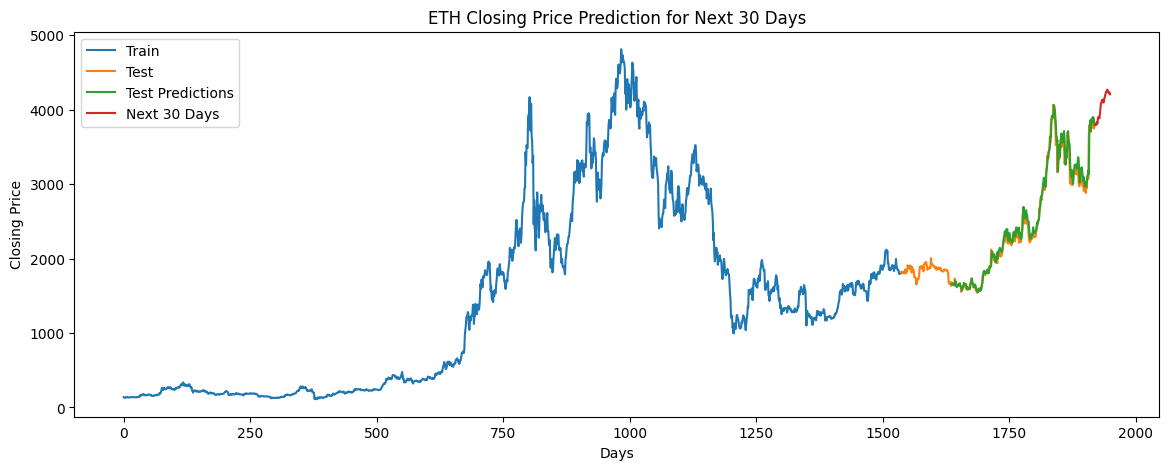

Predicted closing prices for the next 30 days:
[3799.9116 3805.945  3799.0442 3832.5957 3813.5078 3885.2217 3903.692
 3894.4148 3882.8325 3953.649  4024.4587 4082.3801 4097.8135 4130.842
 4133.403  4135.089  4095.3835 4129.5723 4154.991  4185.4175 4207.5684
 4239.923  4243.69   4267.7017 4266.31   4238.431  4223.3516 4221.062
 4232.7373 4206.552 ]


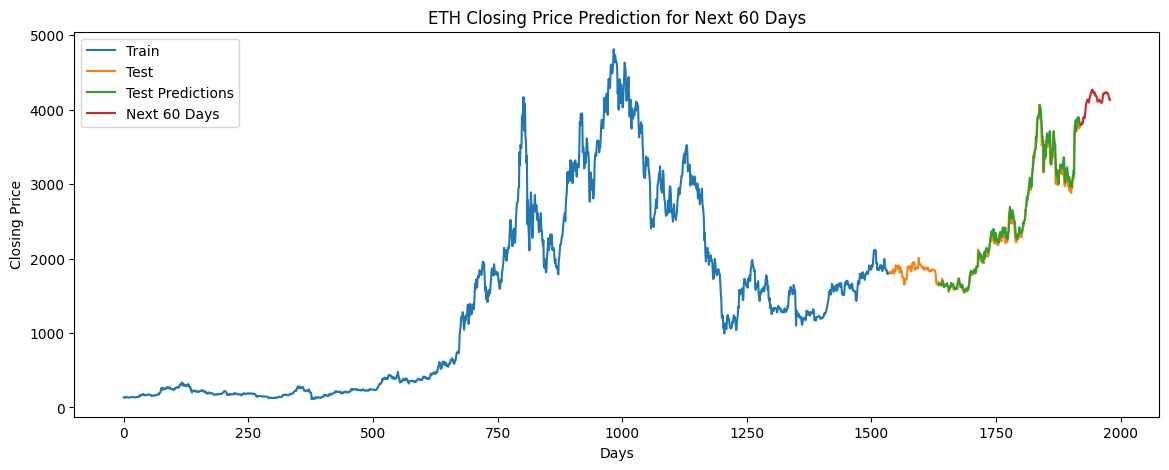

Predicted closing prices for the next 60 days:
[3799.9116 3805.945  3799.0442 3832.5957 3813.5078 3885.2217 3903.692
 3894.4148 3882.8325 3953.649  4024.4587 4082.3801 4097.8135 4130.842
 4133.403  4135.089  4095.3835 4129.5723 4154.991  4185.4175 4207.5684
 4239.923  4243.69   4267.7017 4266.31   4238.431  4223.3516 4221.062
 4232.7373 4206.552  4182.9937 4189.208  4176.9253 4142.732  4104.556
 4123.2314 4131.4165 4135.7627 4114.4346 4123.404  4099.712  4096.7188
 4089.3384 4101.9517 4144.064  4208.3765 4220.3047 4218.1895 4214.715
 4232.086  4232.7344 4223.3804 4229.219  4231.8677 4218.656  4213.0957
 4177.896  4157.6865 4127.5396 4135.183 ]


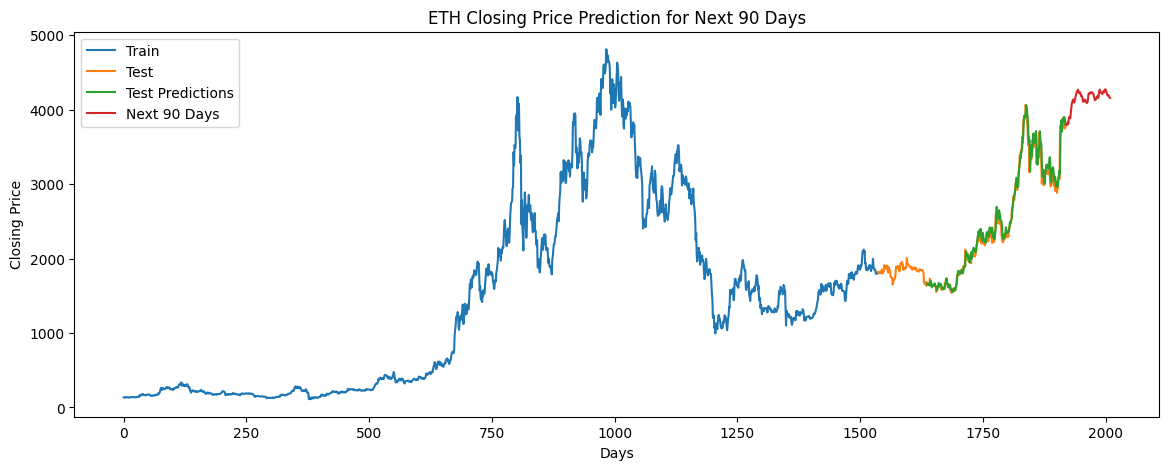

Predicted closing prices for the next 90 days:
[3799.9116 3805.945  3799.0442 3832.5957 3813.5078 3885.2217 3903.692
 3894.4148 3882.8325 3953.649  4024.4587 4082.3801 4097.8135 4130.842
 4133.403  4135.089  4095.3835 4129.5723 4154.991  4185.4175 4207.5684
 4239.923  4243.69   4267.7017 4266.31   4238.431  4223.3516 4221.062
 4232.7373 4206.552  4182.9937 4189.208  4176.9253 4142.732  4104.556
 4123.2314 4131.4165 4135.7627 4114.4346 4123.404  4099.712  4096.7188
 4089.3384 4101.9517 4144.064  4208.3765 4220.3047 4218.1895 4214.715
 4232.086  4232.7344 4223.3804 4229.219  4231.8677 4218.656  4213.0957
 4177.896  4157.6865 4127.5396 4135.183  4136.9243 4149.6006 4167.8013
 4181.504  4180.553  4158.7476 4203.115  4254.234  4269.2764 4245.6226
 4233.554  4225.3477 4222.6724 4207.384  4227.7095 4239.296  4251.904
 4232.51   4257.8594 4272.3335 4272.6475 4250.3716 4227.4834 4201.138
 4191.1177 4195.425  4193.8594 4168.851  4164.8486 4157.026 ]


In [17]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'ETH Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **7:3**

In [43]:
df = pd.read_csv('Eth.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,2019-03-05,127.792953,138.229980,126.735298,137.822388,137.822388,4764849990
...,...,...,...,...,...,...,...
1915,2024-05-28,3892.096924,3924.895752,3771.213867,3840.256348,3840.256348,19846044324
1916,2024-05-29,3840.235107,3880.648438,3742.041260,3763.196533,3763.196533,17411416736
1917,2024-05-30,3763.357666,3823.643311,3702.263672,3746.849609,3746.849609,15065849797
1918,2024-05-31,3746.861572,3843.857666,3723.835205,3760.026611,3760.026611,15290700646


In [19]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [20]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [21]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [22]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [23]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [24]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [25]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
20/20 [==============================] - 5s 125ms/step - loss: 0.0442 - val_loss: 0.0178
Epoch 2/200
20/20 [==============================] - 2s 76ms/step - loss: 0.0121 - val_loss: 0.0055
Epoch 3/200
20/20 [==============================] - 2s 77ms/step - loss: 0.0091 - val_loss: 0.0044
Epoch 4/200
20/20 [==============================] - 2s 77ms/step - loss: 0.0075 - val_loss: 0.0049
Epoch 5/200
20/20 [==============================] - 2s 76ms/step - loss: 0.0060 - val_loss: 0.0035
Epoch 6/200
20/20 [==============================] - 2s 80ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 7/200
20/20 [==============================] - 2s 103ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 8/200
20/20 [==============================] - 3s 129ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 9/200
20/20 [==============================] - 2s 78ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 10/200
20/20 [==============================] - 2s 77ms/step - loss: 0.0038 - val_loss: 0.0

In [26]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

15/15 [==============================] - 0s 15ms/step


In [27]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [28]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 104.10033514463834
Testing MAPE: 3.620369243770108
Testing MAE: 80.38292146381568


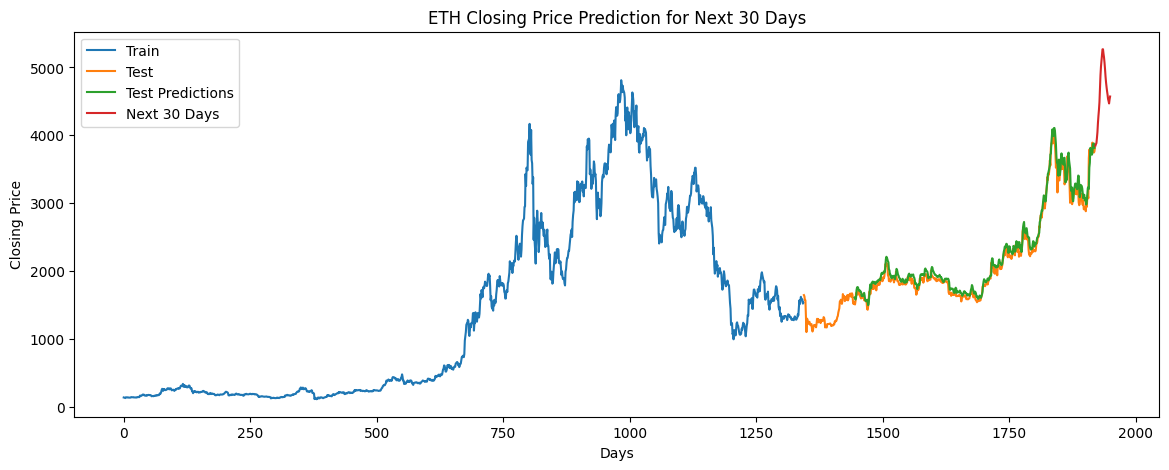

Predicted closing prices for the next 30 days:
[3846.6494 3869.272  3885.0427 3959.904  4046.3093 4180.9277 4285.6655
 4375.5713 4488.554  4683.1313 4882.1934 5012.46   5098.5645 5180.2866
 5267.143  5268.704  5202.383  5148.919  5071.374  4976.245  4866.908
 4780.278  4712.3726 4651.6465 4599.779  4534.605  4504.8184 4469.7827
 4528.424  4571.7915]


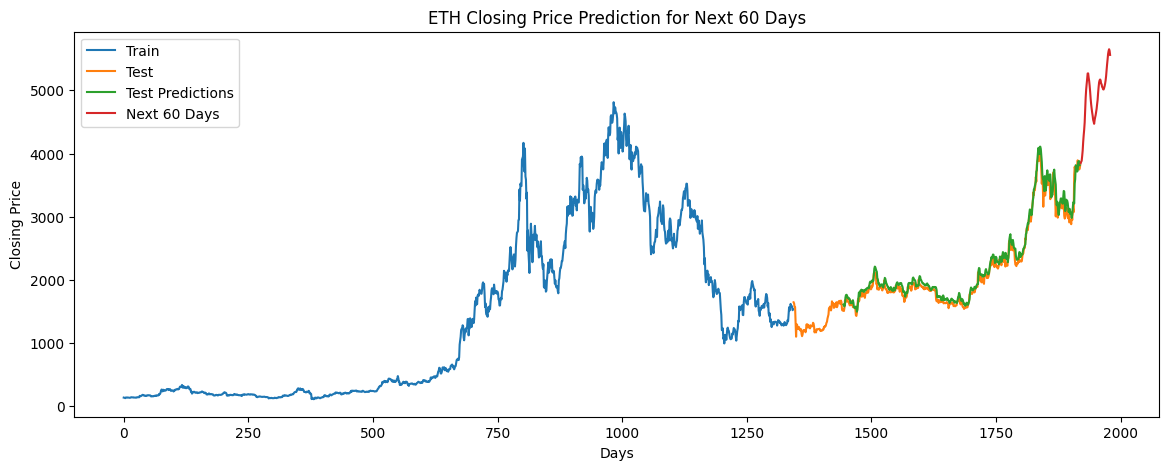

Predicted closing prices for the next 60 days:
[3846.6494 3869.272  3885.0427 3959.904  4046.3093 4180.9277 4285.6655
 4375.5713 4488.554  4683.1313 4882.1934 5012.46   5098.5645 5180.2866
 5267.143  5268.704  5202.383  5148.919  5071.374  4976.245  4866.908
 4780.278  4712.3726 4651.6465 4599.779  4534.605  4504.8184 4469.7827
 4528.424  4571.7915 4607.0264 4657.463  4708.971  4781.869  4848.1997
 4961.125  5052.856  5126.843  5158.7812 5171.3574 5158.137  5105.74
 5096.892  5054.3604 5044.2295 5016.4805 5013.2925 5035.712  5065.175
 5104.127  5156.9243 5224.2266 5320.141  5412.008  5490.2583 5576.2036
 5621.463  5650.799  5625.315  5560.32  ]


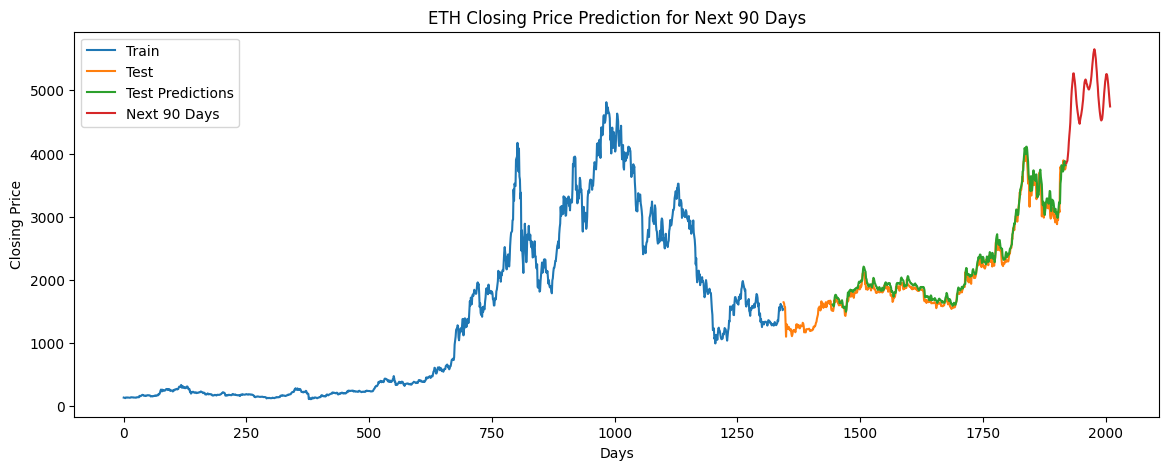

Predicted closing prices for the next 90 days:
[3846.6494 3869.272  3885.0427 3959.904  4046.3093 4180.9277 4285.6655
 4375.5713 4488.554  4683.1313 4882.1934 5012.46   5098.5645 5180.2866
 5267.143  5268.704  5202.383  5148.919  5071.374  4976.245  4866.908
 4780.278  4712.3726 4651.6465 4599.779  4534.605  4504.8184 4469.7827
 4528.424  4571.7915 4607.0264 4657.463  4708.971  4781.869  4848.1997
 4961.125  5052.856  5126.843  5158.7812 5171.3574 5158.137  5105.74
 5096.892  5054.3604 5044.2295 5016.4805 5013.2925 5035.712  5065.175
 5104.127  5156.9243 5224.2266 5320.141  5412.008  5490.2583 5576.2036
 5621.463  5650.799  5625.315  5560.32   5494.427  5380.96   5287.4966
 5150.028  5053.708  4914.5254 4826.3545 4737.013  4661.3877 4599.5737
 4546.1704 4523.095  4532.702  4557.7935 4629.924  4728.737  4846.0093
 4959.3276 5044.699  5138.595  5188.0967 5253.014  5258.152  5236.132
 5179.773  5106.883  5018.862  4919.7505 4823.102  4744.8276]


In [29]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'ETH Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **6:4**

In [30]:
df = pd.read_csv('Eth.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,2019-03-05,127.792953,138.229980,126.735298,137.822388,137.822388,4764849990
...,...,...,...,...,...,...,...
1915,2024-05-28,3892.096924,3924.895752,3771.213867,3840.256348,3840.256348,19846044324
1916,2024-05-29,3840.235107,3880.648438,3742.041260,3763.196533,3763.196533,17411416736
1917,2024-05-30,3763.357666,3823.643311,3702.263672,3746.849609,3746.849609,15065849797
1918,2024-05-31,3746.861572,3843.857666,3723.835205,3760.026611,3760.026611,15290700646


In [31]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [32]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [33]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [34]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [35]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [36]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [37]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
17/17 [==============================] - 5s 184ms/step - loss: 0.0457 - val_loss: 0.0130
Epoch 2/200
17/17 [==============================] - 2s 89ms/step - loss: 0.0113 - val_loss: 0.0058
Epoch 3/200
17/17 [==============================] - 1s 83ms/step - loss: 0.0085 - val_loss: 0.0051
Epoch 4/200
17/17 [==============================] - 1s 85ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 5/200
17/17 [==============================] - 2s 136ms/step - loss: 0.0063 - val_loss: 0.0113
Epoch 6/200
17/17 [==============================] - 2s 109ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 7/200
17/17 [==============================] - 1s 84ms/step - loss: 0.0055 - val_loss: 0.0062
Epoch 8/200
17/17 [==============================] - 1s 86ms/step - loss: 0.0050 - val_loss: 0.0088
Epoch 9/200
17/17 [==============================] - 1s 84ms/step - loss: 0.0045 - val_loss: 0.0058
Epoch 10/200
17/17 [==============================] - 1s 84ms/step - loss: 0.0041 - val_loss: 0.0

In [38]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

21/21 [==============================] - 0s 18ms/step


In [39]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [40]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 179.4038340103587
Testing MAPE: 9.150046506235562
Testing MAE: 153.39021651283673


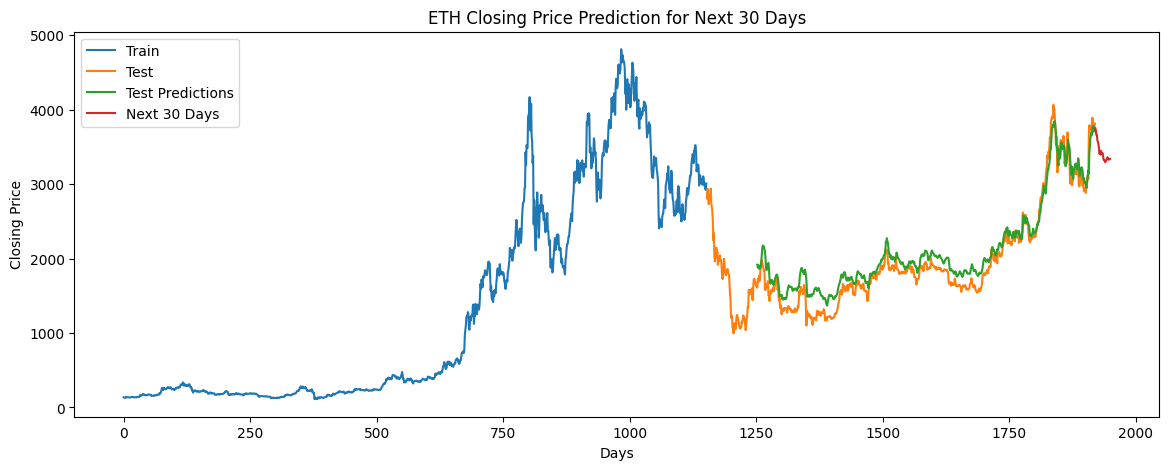

Predicted closing prices for the next 30 days:
[3749.509  3713.543  3658.8604 3655.5547 3584.3503 3568.3677 3532.3608
 3485.203  3405.9639 3419.2712 3397.2202 3447.1423 3417.536  3412.4963
 3418.58   3396.544  3331.799  3324.554  3325.7654 3296.1038 3300.6301
 3312.8562 3322.8462 3348.9954 3360.5378 3350.4363 3329.4587 3330.446
 3333.3306 3338.4094]


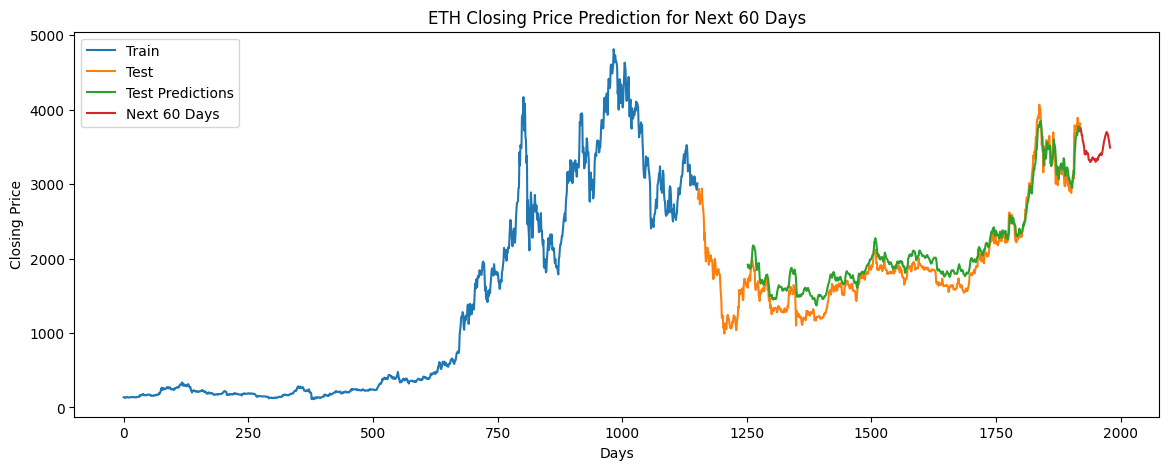

Predicted closing prices for the next 60 days:
[3749.509  3713.543  3658.8604 3655.5547 3584.3503 3568.3677 3532.3608
 3485.203  3405.9639 3419.2712 3397.2202 3447.1423 3417.536  3412.4963
 3418.58   3396.544  3331.799  3324.554  3325.7654 3296.1038 3300.6301
 3312.8562 3322.8462 3348.9954 3360.5378 3350.4363 3329.4587 3330.446
 3333.3306 3338.4094 3298.5872 3323.6892 3323.83   3340.389  3321.6235
 3360.6345 3365.2957 3388.8225 3388.4712 3403.9883 3411.7234 3392.7654
 3390.1528 3416.5342 3453.7048 3498.7415 3538.258  3580.7551 3601.1558
 3636.4138 3657.321  3686.9336 3698.3967 3695.2979 3672.919  3651.1433
 3612.993  3577.3337 3530.6296 3489.8813]


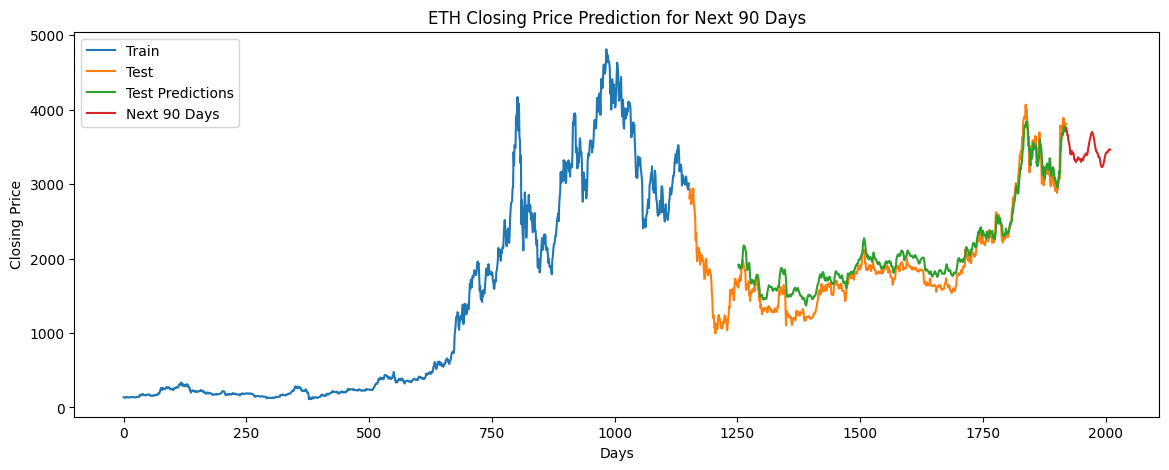

Predicted closing prices for the next 90 days:
[3749.509  3713.543  3658.8604 3655.5547 3584.3503 3568.3677 3532.3608
 3485.203  3405.9639 3419.2712 3397.2202 3447.1423 3417.536  3412.4963
 3418.58   3396.544  3331.799  3324.554  3325.7654 3296.1038 3300.6301
 3312.8562 3322.8462 3348.9954 3360.5378 3350.4363 3329.4587 3330.446
 3333.3306 3338.4094 3298.5872 3323.6892 3323.83   3340.389  3321.6235
 3360.6345 3365.2957 3388.8225 3388.4712 3403.9883 3411.7234 3392.7654
 3390.1528 3416.5342 3453.7048 3498.7415 3538.258  3580.7551 3601.1558
 3636.4138 3657.321  3686.9336 3698.3967 3695.2979 3672.919  3651.1433
 3612.993  3577.3337 3530.6296 3489.8813 3460.0852 3438.1382 3433.7493
 3415.5881 3411.3801 3369.2727 3371.7722 3362.224  3348.7295 3302.7173
 3262.8167 3236.28   3231.877  3228.486  3246.409  3255.4324 3287.5425
 3310.4753 3353.109  3379.7366 3407.5369 3425.0466 3429.2332 3427.0576
 3427.0037 3441.3997 3460.518  3468.7012 3463.1516 3463.2786]


In [41]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'ETH Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())